In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from visualization import contour_generator

(0, 5.8)

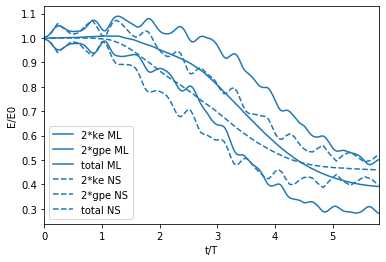

In [8]:
# Stokes energy. Time is scaled by T0

def plot_normalized(ax,energy,tag=' ',line='-',cl='C0'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke*2/(energy.total[0]), label='2*ke '+tag, linestyle=line)
    ax.plot(energy.t, energy.gpe*2/(energy.total[0]), '--', label='2*gpe '+tag, linestyle=line, color=cl)
    ax.plot(energy.t, energy.total/energy.total[0], label='total '+tag, linestyle=line, color=cl)
    ax.set_ylabel("E/E0")

def plot(ax,energy,tag=' ',line='-'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke, label='ke '+tag, linestyle=line)
    ax.plot(energy.t, energy.gpe, label='gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total/2, label='total/2 '+tag, linestyle=line)
    ax.set_ylabel("E")
    
from scipy.signal import argrelextrema
def fit(ax,energy,localmax=1):
    global T
    t = np.array(energy.t); total = np.array(energy.total)/2
    if localmax:
        localmax_index = argrelextrema(total, np.greater)[0]
        localmax_time = t[localmax_index]
        localmax = total[localmax_index]
        ax.plot(localmax_time,localmax,'.')
        a, b = np.polyfit(localmax_time, np.log(localmax), 1)  
    else:
        a, b = np.polyfit(t, np.log(total), 1)
    ax.plot(t, np.exp(b)*np.exp(a*t), linestyle='-.', label = 'a = %g' %(a/T))
    return (a/T)   

def read(name, skip = None):
    energy,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'ke', 'gpe'], skipn = skip)
    if exists:
        total = energy.ke + energy.gpe 
    energy.insert(len(energy.columns), "total", total, True)
    return energy
def read_ns(name, skip = 100):
    energy,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'ke', 'gpe', 'dissipation'], skipn = skip)
    if exists:
        total = energy.ke + energy.gpe 
    energy.insert(len(energy.columns), "total", total, True)
    return energy


fig = plt.figure(); ax = fig.gca()
path = '/home/jiarong/research/projects/multilayer/stokes_ml_RE40000_nl60_N256_coeff0_ak0.35/'
energy1 = read('budget.dat')
plot_normalized(ax,energy1,'ML')
# nu = 4*10**(-5); k = 2*np.pi/1; g = 9.8; T = 2*np.pi/(g*k)**0.5
# a_theory = -4*nu*k**2
# a_fit = fit(ax,energy1,0)
# Since time was scaled
# print("a_theory = %g" %a_theory)
# print("a_fit = %g" %a_fit)
# print("T = %g" %T)

# Comparison with other resolution
# path = '/home/jiarong/research/projects/multilayer/stokes_ml_RE40000_nl60_N256_coeff0_ak0.35/'
# energy2 = read('budget.dat')
# plot(ax,energy2,'uniform 60 layers', '--')

# Comparison with ns
path = '/home/jiarong/research/projects/multilayer/stokes_ns_movie/'
energy2 = read_ns('budgetWater.dat')
# energy2 = energy2.mul([1,9.8,9.8,1,9.8])
plot_normalized(ax,energy2,'NS','--')

plt.legend(loc = 'lower left')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("t/T"); 
plt.xlim([0,5.8])
# plt.ylim([0.002,0.009])

In [23]:
# Computation of breaking coefficient b
kp = 2*np.pi/1; g = 1; cp = (g/kp)**0.5; T = 2*np.pi/(g*kp)**0.5
epsilon_l = 0.4*10**(-4)/(3*T) # After divided by rho
b = epsilon_l*g/cp**5
print("b = %g" %b)
S = 0.35 # or 0.1 if std eta
b_ = 0.4*(S-0.08)**(5/2)
print("b_ = %g" %b_)
print("T = %g" %T)
print("cp = %g" %cp)

b = 0.000526379
b_ = 0.015152
T = 2.50663
cp = 0.398942


In [43]:
# Computational power
clock_ns = 4*40*8
clock_ml = 2*32*(1/6)
clock_ml

10.666666666666666

Text(0.5, 1.0, '256*256 30 layers')

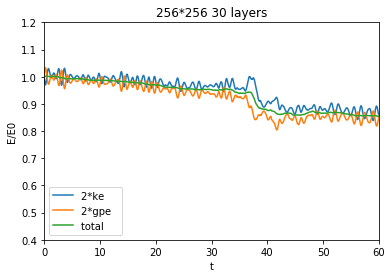

In [9]:
# 1D focusing case. Time is not scaled anymore
fig = plt.figure(); ax = fig.gca()
N = 256; nl = 30
path = '/home/jiarong/research/projects/multilayer/field_focusing_1D_P0010_RE40000_%g_%g/' %(N,nl)
energy1 = read('energy_after_remap.dat')
plot_normalized(ax,energy1)
plt.ylim([0.4,1.2]); 
plt.xlim([0, 60])
plt.legend(loc = 'lower left')
plt.xlabel('t')
plt.title('%g*%g %g layers' %(N,N,nl))

0.2656422


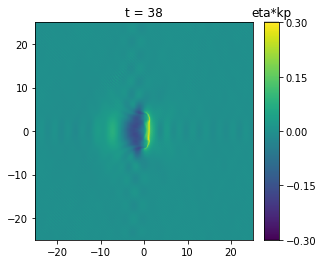

In [27]:
# Short crest focusing case. Wave height.
N = 512; nl = 30; t = 38
pfile = '/home/jiarong/research/projects/multilayer/' + \
        'field_focusing_2D_P0001_RE40000_%g_%g/' %(N,nl) \
        +'surface/eta_matrix_%g' %t
eta = np.fromfile(pfile, dtype=np.float32)
eta = eta.reshape(N+1,N+1)
kp = 2*np.pi/10
eta = eta[1:,1:]*kp # Normalized by peak velocity
image = np.rot90(eta)
figure, grid = contour_generator()
pcontour = grid[0].imshow(image, extent=[-25,25,-25,25], vmax=0.3, vmin=-0.3)
grid[0].set_title('t = %g' %t)
grid[0].cax.colorbar(pcontour)
grid[0].cax.set_title('eta*kp')
# grid[0].set_xlabel('x'); grid[0].set_ylabel('y')
print(np.max(eta))

Text(0.5, 1.0, 'deta/dx')

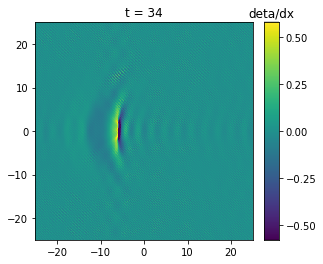

In [25]:
# Short crest focusing case. Slope.
N = 512; nl = 30; t = 34
pfile = '/home/jiarong/research/projects/multilayer/' + \
        'field_focusing_2D_P0001_RE40000_%g_%g/' %(N,nl) \
        +'surface/eta_matrix_%g' %t
eta = np.fromfile(pfile, dtype=np.float32)
eta = eta.reshape(N+1,N+1)
kp = 2*np.pi/10
eta = eta[1:,1:]
L = 50
eta_gradx = np.gradient(eta, axis=0)/(L/N)
eta_gradx = np.rot90(eta_gradx)
figure, grid = contour_generator()
pcontour = grid[0].imshow(eta_gradx, extent=[-L/2,L/2,-L/2,L/2], vmax=0.577, vmin=-0.577)
grid[0].set_title('t = %g' %t)
grid[0].cax.colorbar(pcontour)
grid[0].cax.set_title('deta/dx')
# grid[0].set_xlabel('x'); grid[0].set_ylabel('y')

Text(0.5, 1.0, '512*512 30 layers')

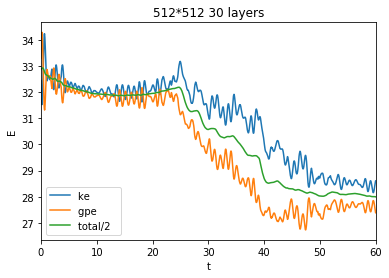

In [10]:
# Short crest focusing case. Time is not scaled anymore
fig = plt.figure(); ax = fig.gca()
N = 512; nl = 30
path = '/home/jiarong/research/projects/multilayer/field_focusing_2D_P00025_RE40000_%g_%g/' %(N,nl)
energy1 = read('energy_after_remap.dat')
plot(ax,energy1)
# plt.ylim([0.4,1.2]); 
plt.xlim([0, 60])
plt.legend(loc = 'lower left')
plt.xlabel('t')
plt.title('%g*%g %g layers' %(N,N,nl))

In [29]:
kp = 2*np.pi/10; g = 9.8; cp = (g/kp)**0.5; T = 2*np.pi/(g*kp)**0.5
epsilon_l = (1)/1/10 # After divided by rho
b = epsilon_l*g/cp**5
print("b = %g" %b)
S = 0.26 # or 0.1 if std eta
b_ = 0.4*(S-0.08)**(5/2)
print("b_ = %g" %b_)
print("T = %g" %T)
print("cp = %g" %cp)

b = 0.00102002
b_ = 0.00549846
T = 2.53208
cp = 3.94933


In [17]:
quat = {0.521116,0.126971,0.264401,0.801503}
view (fov = 17.3106, quat = {0.475152,0.161235,0.235565,0.832313},tx = -0.0221727, ty = -0.0140227, width = 1200, height = 768);
view (fov = 20, quat = {-0.239316,0.369446,0.0990723,0.892425}, tx = 0, ty = 0, bg = {0.3,0.4,0.6}, width = 600, height = 600, samples = 1);
quat = {-0.475152, 0}

-0.5235987755982988

Text(0.5, 0, 't')

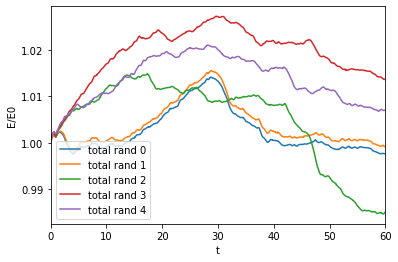

In [15]:
# 4.1 Field scale 
fig = plt.figure(); ax = fig.gca()
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0010_RE40000_9_60_rand0/'
energy1 = read('energy_after_remap.dat')
plot_normalized(ax,energy1, 'rand 0', cl='C0')
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0010_RE40000_9_60_rand1/'
energy2 = read('energy_after_remap.dat')
plot_normalized(ax,energy2, 'rand 1', cl='C1')
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0010_RE40000_9_60_rand2/'
energy2 = read('energy_after_remap.dat')
plot_normalized(ax,energy2, 'rand 2', cl='C2')
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0010_RE40000_9_60_rand3/'
energy2 = read('energy_after_remap.dat')
plot_normalized(ax,energy2, 'rand 3', cl='C3')
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0010_RE40000_9_60_rand4/'
energy2 = read('energy_after_remap.dat')
plot_normalized(ax,energy2, 'rand 4', cl='C4')
plt.legend(loc = 'lower left')
# plt.ylim([0.4,1.2])
plt.xlim([0, 60])
plt.xlabel('t')

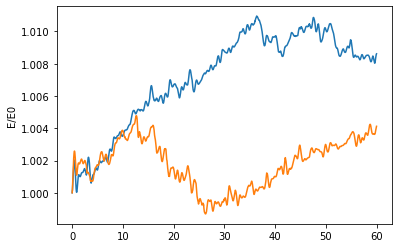

In [4]:
fig = plt.figure(); ax = fig.gca()
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0005_RE40000_9_60_rand0/'
energy1 = read('energy_after_remap.dat')
plot_normalized(ax,energy1, 'rand 0', cl='C0')
path = '/home/jiarong/research/projects/multilayer/field_init_test_P0005_RE40000_9_60_rand4/'
energy2 = read('energy_after_remap.dat')
plot_normalized(ax,energy2, 'rand 1', cl='C1')

In [19]:
# 4.1 Change max slope
print(np.tan(30/180*np.pi))

0.5773502691896257


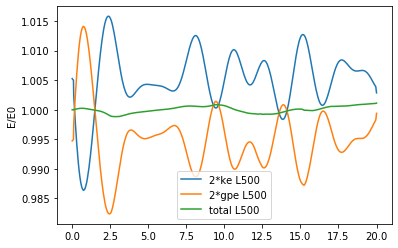

In [15]:
# 5 L = 500m
def plot_normalized(ax,energy,tag=' ',line='-'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke*2/(energy.total[0]), label='2*ke '+tag, linestyle=line)
    ax.plot(energy.t, energy.gpe*2/(energy.total[0]), '--', label='2*gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total/energy.total[0], label='total '+tag, linestyle=line)
    ax.set_ylabel("E/E0")
fig = plt.figure(); ax = fig.gca()
path = '/home/jiarong/research/projects/multilayer/field_L500_P02_RE40000_9_60_coeff01_rand4/'
energy1 = read('energy_after_remap.dat')
plot_normalized(ax,energy1, 'L500')
plt.legend()